# 复制出test-state_corn里面的训练部分的代码，不运行，主要整理格式

In [1]:
import os # Handle OS file systems and directory paths
import random # Random number
import numpy as np # Import NumPy for arrays and such
import matplotlib.pyplot as plt # Plotting Tools
import numpy.linalg as npl # Linear Algebra Library
import time # Time

import pandas as pd # Import Pandas for data processing
import datetime as dt
import scipy.io as sio
# import io
from decimal import Decimal # String to double conversion
from glob import glob  # 从 glob 模块中导入 glob 函数

In [2]:
import tensorflow as tf
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D
from keras.models import Model
import keras
from keras.layers import Dense, TimeDistributed
from keras.models import Sequential
# from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
# from keras.utils import np_utils
import itertools

from keras.layers import LSTM, RepeatVector
# from keras.layers.convolutional import Conv1D,Conv2D
# from keras.layers.convolutional import MaxPooling1D,MaxPooling2D
from keras.layers import Dropout, Flatten
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from numpy import dstack,  hstack
import scipy.io as sio
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn.model_selection import train_test_split


# data_mat = "/content/drive/MyDrive/ai/era5/yield_Iowa_corn_noIrr.mat" #Name of File, may need to specify path
# data_dict = sio.loadmat(data_mat) #Load MAT as a python dictionary
# print(data_dict)


2025-03-23 02:15:27.627645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-23 02:15:32.166571: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-23 02:15:32.190397: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-23 02:15:38.750369: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-23 02:15:46.626957: W tensorflow/com

## 准备训练数据

In [3]:
bucket_name = 'pepper-dataset'

data_feature = pd.read_csv('s3://'+bucket_name+ '/NORTH_DAKOTA_data_feature_expanded_CORN.csv')
data_label = pd.read_csv('s3://'+bucket_name+ '/NORTH_DAKOTA_data_label_expanded_CORN.csv')

# data_feature = pd.read_csv('D:/data/crop_ai/NORTH_DAKOTA_data_feature_expanded_CORN.csv')
# data_label = pd.read_csv('D:/data/crop_ai/NORTH_DAKOTA_data_label_expanded_CORN.csv')

print('Data Feature Shape:',data_feature.shape) # Verify Shape
print('Data Label Shape:',data_label.shape) # Verify Shape


train_X = data_feature
train_y = data_label.T

train_X = np.nan_to_num(train_X)
train_y = np.nan_to_num(train_y)

print(train_X.shape)
print(train_y.shape)

x = np.asarray(train_X, dtype=np.float32)
y = np.asarray(train_y).flatten()

# Training/Validation split 67%, 33% split
data_feature, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print(X_test.shape)
print(data_label.shape)
print(data_feature.shape)

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/fsspec/registry.py:283: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


Data Feature Shape: (105, 87312)
Data Label Shape: (105, 1)
(105, 87312)
(1, 105)
(35, 87312)
(105, 1)
(70, 87312)


## reshape 训练数据

In [4]:
def dataReshape(dataIn,debug=True,runOnce=False):
  """Takes the 1D feature array and reshapes to 270x16"""
  print(dataIn.shape)

  dataOut = []
  for idx in range(len(dataIn)):
    dataTemp = dataIn[idx].reshape(5457, 16) #(216,15) 3240
    if debug: print(dataTemp.shape)
    dataOut.append(dataTemp)

    if runOnce: return -1

  return np.array(dataOut)

data_feature_rs = dataReshape(data_feature,debug=False,runOnce=False)
print(data_feature_rs.shape)

#Reshape test
X_test = dataReshape(X_test,debug=False,runOnce=False)
print(X_test.shape)

(70, 87312)
(70, 5457, 16)
(35, 87312)
(35, 5457, 16)


## 转化为TF数据集，设置训练超参数

In [5]:
# Network Parameters
BATCH_SIZE = 32
NUM_EPOCHS = 200
SHUFFLE_BUFFER_SIZE = 64

# Normalize Data
normalizer = Normalization(axis=-1)
normalizer.adapt(data_feature_rs)
data_feature_norm = normalizer(data_feature_rs)

# Normalize Test
normalizer = Normalization(axis=-1)
normalizer.adapt(X_test)
X_test_norm = normalizer(X_test)


# Split into train and test datasets
# Load the Data into a data loader
train_dataset = tf.data.Dataset.from_tensor_slices((data_feature_norm,y_train.T))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_norm,y_test.T)) #TODO: REPLACE WITH TEST DATASET
DATASET_SIZE = len(data_feature_norm)

# Shuffle & Batch the Datasets
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)



2025-03-23 02:17:32.451759: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [ ]:

def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * np.pow(drop,
           np.floor((1+epoch)/epochs_drop))
   return lrate

## 构建网络，普通

In [6]:
# Build Network
visible = Input(shape= (5457, 16))# (270, 16))

filters1 = 80
filters2 = 64


cnn1 = Conv1D(filters=80, kernel_size=2, activation='relu')(visible)
cnn1 = Dense(64)(cnn1)

cnn1 = MaxPooling1D(pool_size=128)(cnn1)

cnn2 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible)
cnn2 = Dense(64)(cnn2)

cnn2 = MaxPooling1D(pool_size=128)(cnn2)

cnn3 = Conv1D(filters=32, kernel_size=2, activation='relu')(visible)
cnn3 = Dense(64)(cnn3)
cnn3 = MaxPooling1D(pool_size=128)(cnn3)

cnn4 =Conv1D(filters=16, kernel_size=2,activation='relu')(visible)
cnn4 = Dense(64)(cnn4)
cnn4 = MaxPooling1D(pool_size=128)(cnn4)
merged = keras.layers.concatenate([cnn1, cnn2,  cnn3, cnn4], axis=2)
cnn = Dense(16)(merged)
# cnn = LSTM(128,recurrent_dropout=0.1)(cnn)
# cnn =Dense(4)(cnn)
cnn = Flatten()(cnn)
output1 =Dense(1,activation='linear')(cnn)


# tie together
model = Model(inputs=visible, outputs=output1)

model.compile(optimizer='adam', loss='mse', metrics =['accuracy','mean_squared_error','mean_absolute_percentage_error',tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5457, 16)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5456, 80)  │      2,640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5456, 64)  │      2,112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 5456, 32)  │      1,056 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 5456, 16)  │        528 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5456, 64)  │      5,184 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5456, 64)  │      4,160 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5456, 64)  │      2,112 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5456, 64)  │      1,088 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 42, 64)    │          0 │ dense[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 42, 64)    │          0 │ dense_1[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 42, 64)    │          0 │ dense_2[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 42, 64)    │          0 │ dense_3[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 42, 256)   │          0 │ max_pooling1d[0]… │
│ (Concatenate)       │                   │            │ max_pooling1d_1[… │
│                     │                   │            │ max_pooling1d_2[… │
│                     │                   │            │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 42, 16)    │      4,112 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 672)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        673 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,665 (92.44 KB)

 Trainable params: 23,665 (92.44 KB)

 Non-trainable params: 0 (0.00 B)

## 构建网络，resnet

In [ ]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Add
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling1D, concatenate
from tensorflow.keras.models import Model


def residual_block(input_tensor, filters, kernel_size=2):
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Add the input tensor back to the output
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x


# Input layer
visible = Input(shape=(5457, 16))

# First ResNet Pathway
cnn1 = Conv1D(filters=80, kernel_size=2, padding='same', activation='relu')(visible)
cnn1 = residual_block(cnn1, 80)
cnn1 = MaxPooling1D(pool_size=128)(cnn1)

# Second ResNet Pathway
cnn2 = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(visible)
cnn2 = residual_block(cnn2, 64)
cnn2 = MaxPooling1D(pool_size=128)(cnn2)

# Third ResNet Pathway
cnn3 = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')(visible)
cnn3 = residual_block(cnn3, 32)
cnn3 = MaxPooling1D(pool_size=128)(cnn3)

# Fourth ResNet Pathway
cnn4 = Conv1D(filters=16, kernel_size=2, padding='same', activation='relu')(visible)
cnn4 = residual_block(cnn4, 16)
cnn4 = MaxPooling1D(pool_size=128)(cnn4)

# Concatenate the outputs from all paths
merged = concatenate([cnn1, cnn2, cnn3, cnn4], axis=2)

# Fully connected layer after concatenation
cnn = Dense(16)(merged)

# Flatten the output
cnn = Flatten()(cnn)

# Output layer
output1 = Dense(1, activation='linear')(cnn)

# Define the model
model = Model(inputs=visible, outputs=output1)

model.compile(optimizer='adam', loss='mse', metrics =['accuracy','mean_squared_error','mean_absolute_percentage_error',tf.keras.metrics.RootMeanSquaredError()])
model.summary()


## 训练

Epoch 1/200
3/3 - 6s - 2s/step - accuracy: 0.0000e+00 - loss: 18684.3691 - mean_absolute_percentage_error: 97.7517 - mean_squared_error: 18684.3691 - root_mean_squared_error: 137.5113 - val_accuracy: 0.0000e+00 - val_loss: 16223.2197 - val_mean_absolute_percentage_error: 92.4803 - val_mean_squared_error: 16223.2197 - val_root_mean_squared_error: 133.4877
Epoch 2/200
3/3 - 1s - 433ms/step - accuracy: 0.0000e+00 - loss: 17202.7188 - mean_absolute_percentage_error: 91.1274 - mean_squared_error: 17202.7188 - root_mean_squared_error: 132.6698 - val_accuracy: 0.0000e+00 - val_loss: 14624.8105 - val_mean_absolute_percentage_error: 87.8344 - val_mean_squared_error: 14624.8105 - val_root_mean_squared_error: 130.7265
Epoch 3/200
3/3 - 1s - 394ms/step - accuracy: 0.0000e+00 - loss: 15452.5889 - mean_absolute_percentage_error: 86.8416 - mean_squared_error: 15452.5889 - root_mean_squared_error: 129.4653 - val_accuracy: 0.0000e+00 - val_loss: 12596.8799 - val_mean_absolute_percentage_error: 83.2806 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5457, 16)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5456, 80)  │      2,640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5456, 64)  │      2,112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 5456, 32)  │      1,056 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 5456, 16)  │        528 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5456, 64)  │      5,184 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5456, 64)  │      4,160 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5456, 64)  │      2,112 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5456, 64)  │      1,088 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 42, 64)    │          0 │ dense[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 42, 64)    │          0 │ dense_1[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 42, 64)    │          0 │ dense_2[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 42, 64)    │          0 │ dense_3[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 42, 256)   │          0 │ max_pooling1d[0]… │
│ (Concatenate)       │                   │            │ max_pooling1d_1[… │
│                     │                   │            │ max_pooling1d_2[… │
│                     │                   │            │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 42, 16)    │      4,112 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 672)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        673 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,997 (277.34 KB)

 Trainable params: 23,665 (92.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,332 (184.89 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Test Loss: [85.72497]
Test Mean Squared Error: [137.35239]
Test Mean Absolute Percentage Error: [130.61649]
Test Root Mean Squared Error: [113.82906]


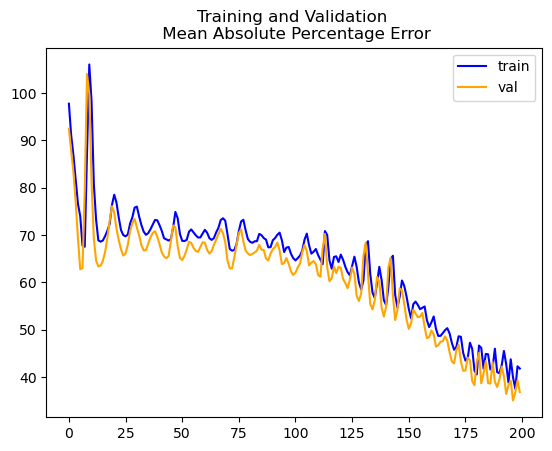

In [7]:
# FIT model with TRAINING DATA
history = model.fit(train_dataset, validation_data=test_dataset,epochs=NUM_EPOCHS,verbose=2)
model.summary()

# EVALUATE model with TESTING DATA
model.evaluate(test_dataset, verbose=0)

ynew = model.predict(test_dataset)
print(f'Test Loss: {ynew[0]}')
print(f'Test Mean Squared Error: {ynew[1]}')
print(f'Test Mean Absolute Percentage Error: {ynew[2]}')
print(f'Test Root Mean Squared Error: {ynew[3]}')

fig, ax = plt.subplots()
ax.set_title('Training and Validation \n Mean Absolute Percentage Error') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['mean_absolute_percentage_error'], color = 'blue', label = 'train')

# plt.title('Validation Mean Absolute Percentage Error (MAPE)') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['val_mean_absolute_percentage_error'], color = 'orange', label = 'val')
ax.legend()

## 训练，Reduce LR on Plateau

In [ ]:
# FIT model with TRAINING DATA
# history = model.fit(train_dataset, validation_data=test_dataset,epochs=NUM_EPOCHS,verbose=2)



from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # 监控的指标，可以改成其他指标如 'val_mean_squared_error'
    factor=0.5,              # 学习率减少的因子，new_lr = lr * factor
    patience=10,             # 当监控指标在'patience'个epoch内没有改善时，减少学习率
    min_lr=1e-6,             # 学习率的下限
    verbose=1                # 设置为1可以看到学习率变化的日志
)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'mean_squared_error', 'mean_absolute_percentage_error', tf.keras.metrics.RootMeanSquaredError()])

# Train the model with ReduceLROnPlateau callback
history = model.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=test_dataset,  # 假设有验证集
    callbacks=[reduce_lr]
)

model.summary()

# EVALUATE model with TESTING DATA
model.evaluate(test_dataset, verbose=0)

ynew = model.predict(test_dataset)
print(f'Test Loss: {ynew[0]}')
print(f'Test Mean Squared Error: {ynew[1]}')
print(f'Test Mean Absolute Percentage Error: {ynew[2]}')
print(f'Test Root Mean Squared Error: {ynew[3]}')

fig, ax = plt.subplots()
ax.set_title('Training and Validation \n Mean Absolute Percentage Error') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['mean_absolute_percentage_error'], color = 'blue', label = 'train')

# plt.title('Validation Mean Absolute Percentage Error (MAPE)') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['val_mean_absolute_percentage_error'], color = 'orange', label = 'val')
ax.legend()

## 测试

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from tensorflow.keras.models import load_model
import numpy as np

# 重置数据集
def create_test_dataset(X_test_norm, y_test):
    return tf.data.Dataset.from_tensor_slices((X_test_norm, y_test.T)).batch(64)

# 创建测试数据集
test_dataset = create_test_dataset(X_test_norm, y_test)

# EVALUATE model with TESTING DATA
results = model.evaluate(test_dataset, verbose=0)
print(f'Test Loss: {results[0]}')
print(f'Test Mean Squared Error: {results[1]}')
print(f'Test Mean Absolute Percentage Error: {results[2]}')
print(f'Test Root Mean Squared Error: {results[3]}')

# PREDICT with TESTING DATA
ynew = model.predict(test_dataset)

# 重置测试数据集
test_dataset = create_test_dataset(X_test_norm, y_test)

# EVALUATE model again with TESTING DATA
results = model.evaluate(test_dataset, batch_size=64)
print(f'loss: {results[0]} - accuracy: {results[1]} - mean_squared_error: {results[2]} - mean_absolute_percentage_error: {results[3]} - root_mean_squared_error: {results[4]}')


In [ ]:
# plt.figure()
# plt.title('Loss (Mean Squared Error)')
# plt.plot(history.history['loss'])
# plt.figure()
# plt.title('Accuracy')
# plt.plot(history.history['accuracy'])
# plt.figure()
# plt.title('Mean Squared Error')
# plt.plot(history.history['mean_squared_error'])
# plt.figure()
fig, ax = plt.subplots()
ax.set_title('Training and Validation \n Mean Squared Error') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['loss'], color = 'blue', label = 'train')
# plt.figure()
## Validation Plots
# plt.title('Validation Loss (MSE)') # loss = 100 * abs(y_true - y_pred) / y_true
# plt.plot(history.history['val_loss'])
# plt.figure()

# plt.title('Validation Mean Absolute Percentage Error (MAPE)') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['val_loss'], color = 'orange', label = 'val')
ax.semilogy((0,50))
ax.legend()
# plt.figure()

In [ ]:
y_pred = model.predict(X_test)

# 计算评估指标
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)  # RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')